# Spatial equilibrium

## Necessary Imports

We import libraries and user defined objects.

1. `auxiliary_functions.jl` contains functions to generate spatial noise, create a graph object and other stuff.
2. `custom_structs.jl` contains the struct arrays used for initial guesses, infrastructure, and model parameters.
3. `model_objects.jl` contains the functions to generate model objects like price indices, trade shares, etc
4. `eqbm_functions.jl` contains functions to solve for the equilibrium. 

Finally, we set a seed for reproducibility.

In [256]:
using Random, LinearAlgebra, Statistics, FFTW, Plots, FastMarching, LightGraphs, SimpleWeightedGraphs

# User-defined inputs
include("auxiliary_functions.jl")
include("custom_structs.jl")
include("model_objects.jl")
include("eqbm_functions.jl")

# Set global random stream
Random.seed!(1234)

MersenneTwister(1234)

## The Geography

We create a geography with randomly generated TFPs with certain spatial correlation. Each location is denoted by a pixel in an $N\times N$ grid.

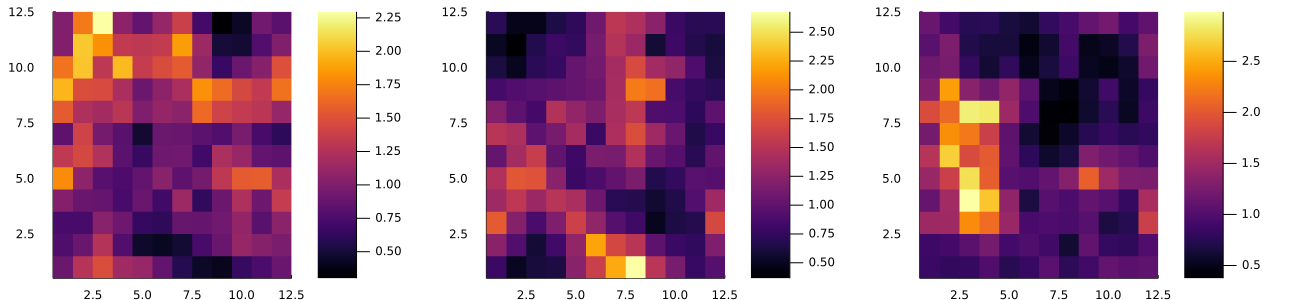

In [283]:
# Geography
N = 12
NN = N^2

# Spatial TFPs
Aa, Am, As = spatial_tfps(N,-2.6)

pa = heatmap(Aa)
pm = heatmap(Am)
ps = heatmap(As)

plot(pa,pm,ps,layout =(1, 3), size = (1300, 300))

In [284]:
# Reshape TFPs
Aa = reshape(Aa,NN,1)
Am = reshape(Am,NN,1)
As = reshape(As,NN,1)

Amat = hcat(Aa, Am, As)
size(Amat)

(144, 3)

Next we generate constant parameters and the geography of the terrain including random *ruggedness*.

In [285]:
# Fundamental parameters
# Elasticities of substitution
rho  = 1.0      # Across sectors
sigm = 5.0      # Across varieties
bbi  = -0.3     # Amenities parameter
nu   = 0.97     # 1 - nu = exp in electricity

# Utility weights
oma = 0.177
omm = 0.325
oms = 1-oma-omm

# From Perez-Sebastian, Steinbuks, Feres, and Trotter (2019)    Table 5
ba = 0.509
bm = 0.335
bs = 0.644

betas = [ba, bm, bs]

# Spillovers
alphT = [0.11, 0.09, 0.05]
iotT = [0.11, 0.09, 0.05]
muT = [0.01, 0.05, 0.05]

# Elasticity of transport costs to infrastructure
gamm = 0.84

# Elasticity of quality of electricity to investment
phi = 0.28

# Randomness on ruggedness of terrain
rugg = ones(N,N) #exp.(randn(N,N))
rugg = N.*ones(size(rugg))./rugg
rugg = 10 ./ rugg

# Distance through terrain
delT = zeros(NN,NN)
index = CartesianIndices(ones(N,N))
rows = map(i -> i[1], index)
cols = map(i -> i[2], index)
rows = rows[:]
cols = cols[:]
for z in 1:NN
    strt = [float(rows[z]); float(cols[z])] # The starting point has to be a column vector
    temp = FastMarching.msfm(rugg, strt, true, true) # Use second derivatives and cross derivatives
    delT[z,:] = reshape(temp,1,NN) .* 10
end

delT[diagind(delT)] .= 1
delT = delT.^(1/4)

# Make sure it is symmetric
delT = (delT + delT') ./ 2.0
delT[delT .< 1] .= 1

# Parameters for the quality of electricity
delG = reshape(rugg.^(1/3),NN,1);

Since we are dealing with a network, we now generate a connected undirected graph with unweighted edges.

In [286]:
A = create_map(N,N)
index = findall(x -> x == 1, A)
rows = map(i -> i[1], index)
cols = map(i -> i[2], index)
rows = rows[:]
cols = cols[:]
edges = [rows cols];

In [287]:
adj = SimpleGraph(NN)

for (r, c) in zip(edges[:,1],edges[:,2])
    add_edge!(adj, Int(r), Int(c))
end

In [288]:
#graphplot(adj, curves = false)

Now we add the infrastructure investment on roads and compute the transport costs. Below we show the heatmap of transport costs for the location in the first corner of the grid. This heatmap shows that the closer regions have smaller trading costs and these increase with distance.

In [289]:
# Budget
Z = 2.5*ne(adj)

# Allocate investment equally
I0 = (Z/(2.001*ne(adj)))*A
index = findall(x -> x == 0, I0)
I0[index] .= 1e-2
I0 = I0.*A
I0 = (I0 + I0') / 2.0;

In [290]:
# Transport cost
T, Tnet = transport_cost(delT,I0,gamm,N);

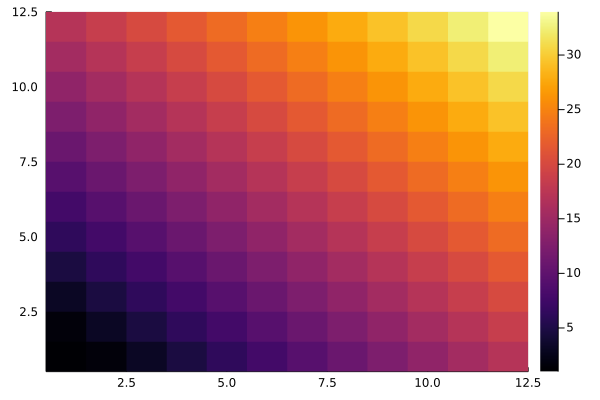

In [291]:
heatmap(reshape(T[1,:],N,N))

In [292]:
# Electricity inputs
shares = ones(NN,1) .* (1/NN)
gwh = 100
Ei = (gwh.*shares).*ones(NN,1)

L = 100; # Total population

We generate now spatially correlated amenities and initialize model parameters as a struct array.

In [293]:
nui = spatial_amenities(N)
nui = reshape(nui,NN,1);

In [294]:
typeof(Tnet)

SimpleWeightedGraph{Int64, Float64}

In [295]:
# Initialize parameters
mparams = model_params(rho,sigm,bbi,nu,oma,omm,oms,gamm,phi,L,NN,betas,alphT,iotT,muT,T,delG,Tnet,Ei,nui,Amat);

Finally, initialize the infrastructure and initial guess structs and solve for the equilibrium.

In [296]:
Vi0 = Z/(2.001*NN).*ones(NN,1);
infras = infrastructure(I0,Vi0)

infrastructure{Matrix{Float64}, Matrix{Float64}}([0.0 1.249375312343828 … 0.0 0.0; 1.249375312343828 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.249375312343828; 0.0 0.0 … 1.249375312343828 0.0], [2.290521405963685; 2.290521405963685; … ; 2.290521405963685; 2.290521405963685])

In [297]:
iniguess = guess(ones(NN,1).*(L/NN),ones(NN,1),ones(NN,1));

## Export Data

Export the generated data to a `.csv` file so that we can compare solutiion times with Matlab correctly.

In [298]:
using DelimitedFiles

writedlm("sim_tfps.csv", Amat, ',')
writedlm("sim_nuis.csv", nui, ',')
writedlm("sim_tcst.csv", T, ',')

In [299]:
init_eqbm = @time endog_eqbm_dispersion(mparams,iniguess,infras)

Iteration: 150
Max diff: 1.2354911373801936e-8
-------------------------------------------


LoadError: InterruptException: